In [17]:
%load_ext autoreload
%autoreload 2

from collections import namedtuple

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader

from datasets.mnist import MNISTTrain, MNISTTest

plt.style.use("seaborn-v0_8")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_dst = MNISTTrain()
test_dst = MNISTTest()

In [3]:
train_dst[0]

(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,

In [4]:
img, label = train_dst[0]

Text(0.5, 1.0, '8')

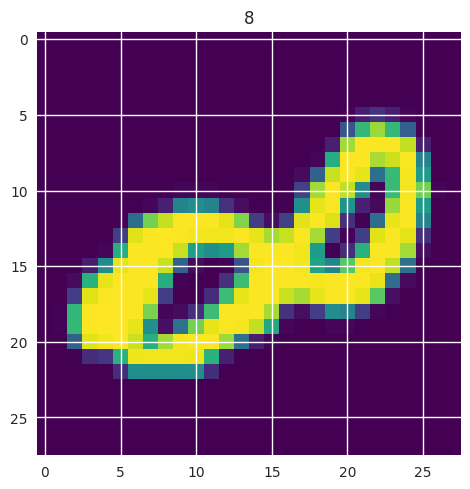

In [5]:
plt.imshow(img, cmap='viridis')
plt.title(str(label))

In [6]:
np.random.seed(0)
torch.manual_seed(0)
train_dst = MNISTTrain(transform=Compose([ToTensor()]))
test_dst = MNISTTest()
train_sample_size, test_sample_size = 250000, 10
train_data = next(iter(DataLoader(dataset=train_dst, 
                        batch_size=train_sample_size, 
                        shuffle=True)))
test_data = next(iter(DataLoader(dataset=test_dst, 
                        batch_size=test_sample_size, 
                        shuffle=False)))

In [7]:
train_data[0].size()

torch.Size([240000, 1, 28, 28])

In [8]:
train_data[0][0].size()

torch.Size([1, 28, 28])

In [9]:
test_data[0].size()

torch.Size([10, 28, 28])

In [10]:
targets = train_data[1].clone()
targets = torch.nn.functional.one_hot(targets)
targets = targets.sum(0)
targets

tensor([24000, 24000, 24000, 24000, 24000, 24000, 24000, 24000, 24000, 24000])

In [11]:
class NaivesBayesMnist:
    
    def __init__(self, data):
        self.img, self.labels = data
        self.img_scaled = self.img.squeeze() / 255.0
        self.size = self.img.size()[2:]
        self.nclass = len(self.labels.unique())
        
        self.model = None
        
    def fit2(self):
        b, h, w = self.img_scaled.size()
        img = self.img_scaled.view(b, h* w, 1).clone()
        labels = torch.nn.functional.one_hot(self.labels)
        img = img * labels.unsqueeze(1)
        img = img.view(b, h, w, -1)
        
        mask_img = img.ge(torch.tensor(0.3)).float()
        img = mask_img.sum(dim=0)
        model = img.float() / (img.sum(axis=-1, keepdim=True)  + 1e-8)
        self.model = model
        self.plot_model()
        
        
    def fit(self):
        b, h, w = self.img_scaled.size()
        img = self.img_scaled.ge(torch.tensor(0.5))
        model = torch.zeros(h, w, self.nclass)
        for label in range(self.nclass):
            target = img[self.labels.eq(torch.tensor(label).long())]
            model[:, :, label] = target.sum(0)
        self.model = model
        self.model = self.model / (self.model.sum(-1, keepdim=True) + 1e-8)
        self.plot_model()
        

    def plot_model(self):
        assert self.model is not None, "Wrong value for model"
        fig, axes = plt.subplots(nrows=1, ncols=self.nclass, figsize=(20, 50))
        for label in range(self.nclass):
            ax = axes[label]
            img = self.model.index_select(-1, torch.tensor(label).long()).clone().detach().cpu().numpy()
            ax.imshow(img)
            ax.set_title(str(label))            
        
                

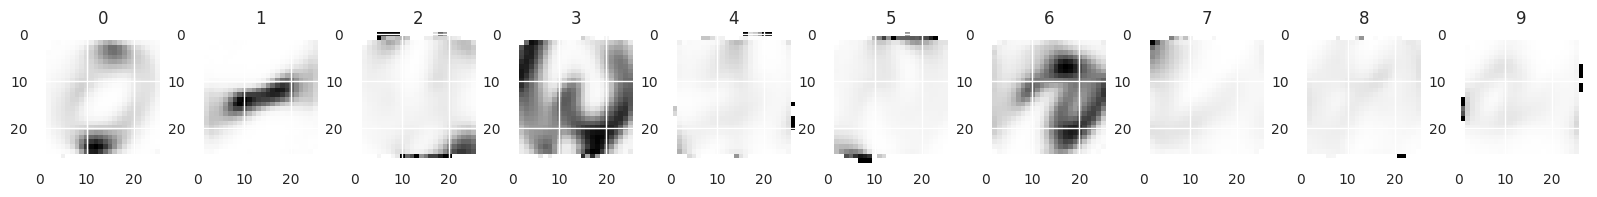

In [12]:
NaivesBayesMnist(train_data).fit2()

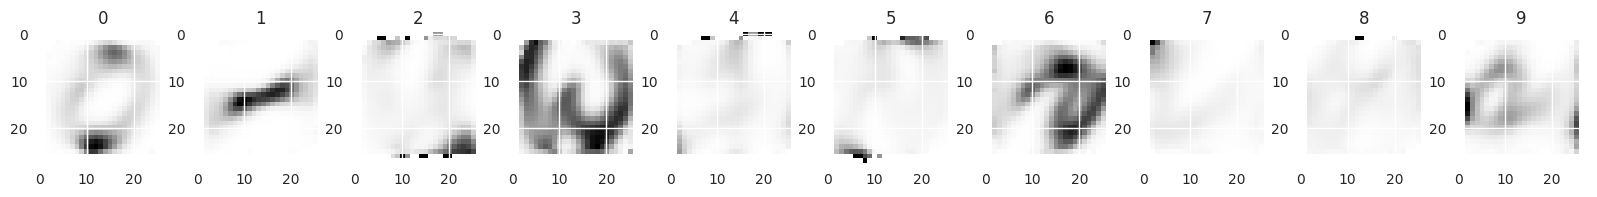

In [13]:
NaivesBayesMnist(train_data).fit()

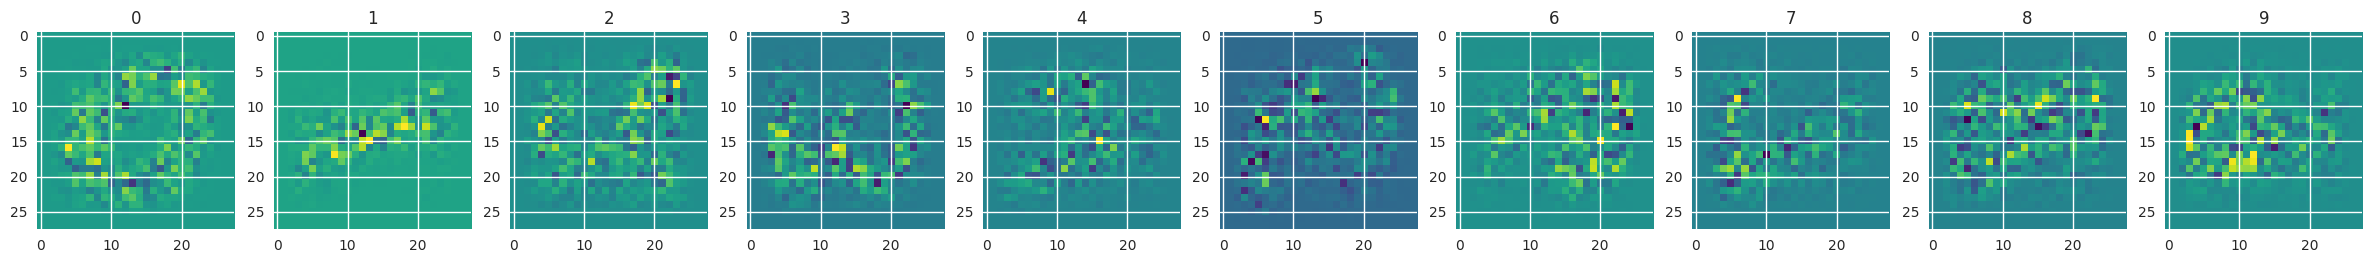

In [28]:
Model = namedtuple("Model", ["mean", "variance"])

class NaivesBayesGaussianMnist:
    
    def __init__(self, data):
        self.img, self.labels = data
        self.img_scaled = self.img.squeeze()
        self.size = self.img.size()[2:]
        self.nclass = len(self.labels.unique())
        
        self.model = None
        
    def fit(self):
        b, h, w = self.img_scaled.size()
        img = self.img_scaled.view(b, h* w, 1).clone()
        labels = torch.nn.functional.one_hot(self.labels)
        img = img * labels.unsqueeze(1)
        img = img.view(b, h, w, -1)
        mean = img.sum(0) / 24000.
        variance = (img - mean).square().sum(0) / 24000.
        self.model = Model(mean=mean, variance=variance)
        self.plot_model()

    def plot_model(self):
        assert self.model is not None, "Wrong value for model"
        fig, axes = plt.subplots(nrows=1, ncols=self.nclass, figsize=(30, 50))
        for label in range(self.nclass):
            ax = axes[label]
            mean = self.model.mean.index_select(-1, torch.tensor(label).long()).clone().squeeze().detach().cpu().numpy()
            variance = self.model.variance.index_select(-1, torch.tensor(label).long()).clone().squeeze().detach().cpu().numpy()
            epsilon = np.random.standard_normal((mean.shape[0], mean.shape[1]))
            img = mean + epsilon * np.sqrt(variance)
            
            ax.imshow(img, cmap="viridis")
            ax.set_title(str(label))     

NaivesBayesGaussianMnist(train_data).fit()